In [1]:
import time
import csv
from json import load
from math import ceil
import numpy as np
import scipy
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
def MichaelisMenten(t, y, params):
    S = params['S_0'] - y
    dP_dt = ( (params['k_cat'] * params['E_0']) * S ) / ( params['K_M'] + S )
    return dP_dt

In [3]:
def solve_MichaelisMenten(params):
    # we need to use lambda function if we want to pass some parameters
    solution = solve_ivp(lambda t, y: MichaelisMenten(t, y, params), 
                         t_span = (params['t0'], params['t1']), y0 = params['y0'], 
                         method='RK45', t_eval=params['t_points'])
    y_points = np.asarray(solution.y[0,:])
    return params['t_points'], y_points

In [4]:
def loss(y_real, y_model):
    return np.linalg.norm(y_real - y_model, ord=2) / y_real.shape[0]

In [5]:
def objective(x, *args):
    params = args[0].copy()
    params['k_cat'] = x[0]
    params['K_M'] = x[1]
    _, y_model = solve_MichaelisMenten(params)
    return loss(args[1], y_model)

In [6]:
def config2args(config):
    args = {}
    args['file'] = str(config["file_name"]["file"])
    args['E_0'] = float(config["experiment_details"]["E_0"])
    args['S_0'] = float(config["experiment_details"]["S_0"])
    args['S_1'] = float(config["experiment_details"]["S_1"])
    args['h'] = float(config["experiment_details"]["h"]) / 60.
    args['exp_last'] = float(config["experiment_details"]["exp_last"])

    args['low_K_M'] = float(config["abc_details"]["low_K_M"])
    args['high_K_M'] = float(config["abc_details"]["high_K_M"])
    args['low_k_cat'] = float(config["abc_details"]["low_k_cat"])
    args['high_k_cat'] = float(config["abc_details"]["high_k_cat"])

    args['N'] = int(config["abc_details"]["N"])
    args['No_sim'] = int(config["abc_details"]["No_sim"])
    args['points_prior'] = int(config["abc_details"]["points_prior"])

    return args

def args2params(args, t_points, x0, y0):
    params = {}
    params['E_0'] = args['E_0']
    params['S_0'] = args['S_0']

    params['k_cat'] = x0[0]
    params['K_M'] = x0[1]
    
    params['t0'] = t_points[0]
    params['t1'] = t_points[-1] + 1.
    params['y0'] = y0
    params['t_points'] = t_points

    return params

In [7]:
def load_data(args, row_value=0):    
    file_name = args['file']

    # LOAD DATA
    with open(file_name, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        counter = 0
        v = []
        for row in reader:
            if counter==row_value:
                for i in range(len(row)):
                    v.append(float(row[i]))
                break
            counter+= 1

    if len(v) == 0:
        raise Exception("Something wrong with data loading! Please check csv file.")

    # set as numpy array
    v = np.asarray(v)

    # how long the experiment lasts (max is 15 min)
    if args['exp_last'] > 15.:
        exp_last = 15.
    else:
        exp_last = args['exp_last']
    
    # get data
    A = v[0:int(ceil(exp_last/args['h']))]
    # repeat data
#     P_real = np.repeat(np.expand_dims(np.asarray(A),0), args['N'], axis=0)
    P_real = A
    # time points
#     t_points = np.arange(0, args['h']*P_real.shape[1], args['h'])
    t_points = np.arange(0, args['h']*P_real.shape[0], args['h'])

    return P_real, t_points

In [8]:
json_name = 'hAPN.json'
with open(json_name) as f:
    config = load(f)
args = config2args(config)

In [9]:
y_real, t_real = load_data(args, 0)

In [10]:
bounds = [(0., 100. * 60.), (0., 200.)]
x0 = np.array([np.random.uniform(bounds[0][0], bounds[0][1]), #k_cat
              np.random.uniform(bounds[1][0], bounds[1][1])]) #K_M
params = args2params(args, t_real, x0=x0, y0=[0.])

In [11]:
# res = opt.minimize(objective, x0, args=(params, y_real), method='nelder-mead', options={'xtol': 1e-8, 'disp': False}) # not working...
# res = opt.shgo(objective, bounds, args=(params, y_real)) # not working...
# res = opt.basinhopping(objective, x0, minimizer_kwargs={'args': (params, y_real)}) seems not working...

In [19]:
tic = time.time()
res = opt.minimize(objective, x0, args=(params, y_real), method='powell', options={'xtol': 1e-8, 'disp': False}) # OK
toc = time.time()
params['k_cat'] = res.x[0]
params['K_M'] = res.x[1]
_, y_powell = solve_MichaelisMenten(params)
print('Powell method: k_cat=', params['k_cat']/60., 'K_M=', params['K_M'], 'time elapsed=', toc-tic)

('Powell method: k_cat=', 5.24672490176063, 'K_M=', 68.09866768239804, 'time elapsed=', 0.1072089672088623)


In [22]:
tic = time.time()
res = opt.differential_evolution(objective, bounds, args=(params, y_real)) # OK
# res = opt.dual_annealing(objective, bounds, args=(params, y_real)) #OK
toc = time.time()
params['k_cat'] = res.x[0]
params['K_M'] = res.x[1]
_, y_de = solve_MichaelisMenten(params)
print('Differential evolution: k_cat=', params['k_cat']/60., 'K_M=', params['K_M'], 'time elapsed=', toc-tic)

('Differential evolution: k_cat=', 4.740884681089991, 'K_M=', 23.08779769777945, 'time elapsed=', 0.5943200588226318)


In [23]:
tic = time.time()
res = opt.dual_annealing(objective, bounds, args=(params, y_real)) #OK
toc = time.time()
params['k_cat'] = res.x[0]
params['K_M'] = res.x[1]
_, y_annealing = solve_MichaelisMenten(params)
print('Dual annealing: k_cat=', params['k_cat']/60., 'K_M=', params['K_M'], 'time elapsed=', toc-tic)

('Dual annealing: k_cat=', 6.575710631247952, 'K_M=', 186.4776784768784, 'time elapsed=', 4.166609048843384)


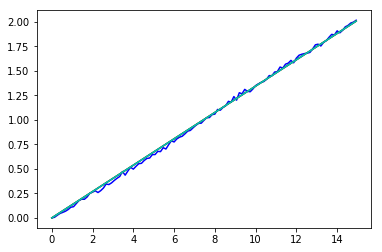

In [15]:
plt.plot(t_real, y_real, 'b-')
plt.plot(t_real, y_powell, 'r-')
plt.plot(t_real, y_de, 'g-')
plt.plot(t_real, y_annealing, 'c-')
plt.show()

In [16]:
loss(y_real, y_powell)

0.002005553145476739

In [17]:
loss(y_real, y_de)

0.0020017956120302366

In [18]:
loss(y_real, y_annealing)

0.0020046511531052126